In [ ]:
# default_exp nrt

# Predict NRT
>This module has functions to generate the burned areas predictions for near real time operational applications.

**Note:** This module is currently being tested.

In [ ]:
# export
import pandas as pd
from datetime import date
import scipy.io as sio
import requests
import IPython
import matplotlib.pyplot as plt
from nbdev.imports import test_eq
from geoget.download import run_all
from banet.core import filter_files, ls, Path, InOutPath
from banet.geo import Region
from banet.data import *
from banet.predict import predict_nrt
Path.ls = ls

In [ ]:
# hide
from nbdev.showdoc import show_doc
from nbdev.export import notebook2script
from IPython.core.debugger import set_trace

In [ ]:
# export
class ProjectPath():
    def __init__(self, path:Path, config_dir='config', ladsweb_dir='ladsweb',
                 hotspots_dir='hotspots', dataset_dir='dataset', outputs_dir='outputs'):
        if isinstance(path, str): path = Path(path)
        self.path     = path
        self.config   = path/config_dir
        self.ladsweb  = path/ladsweb_dir
        self.hotspots = path/hotspots_dir
        self.dataset  = path/dataset_dir
        self.outputs  = path/outputs_dir
        self.create_dirs([self.path, self.config, self.ladsweb, self.hotspots,
                          self.dataset, self.outputs])
        
    @staticmethod
    def create_dirs(paths_list):
        "Create directories in list."
        for o in paths_list: o.mkdir(exist_ok=True)

In [ ]:
show_doc(ProjectPath.create_dirs)

<h4 id="ProjectPath.create_dirs" class="doc_header"><code>ProjectPath.create_dirs</code><a href="__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>ProjectPath.create_dirs</code>(**`paths_list`**)

Create directories in list.

In [ ]:
paths = ProjectPath('../hide/nrt_test')
test_eq(sorted([o.name for o in paths.path.iterdir()]), 
        ['config', 'dataset', 'hotspots', 'ladsweb', 'outputs'])

In [ ]:
# export
class RunManager():
    def __init__(self, project_path:ProjectPath, region, time='today', 
                 product:str='VIIRS750', days=64):
        self.path    = project_path
        self.time    = self.init_time(time)
        self.product = product
        self.region  = region
        self.days    = days
        
    def init_time(self, time):
        if time == 'today': 
            time = pd.Timestamp(date.today())
        elif time == 'yesterday':
            time = pd.Timestamp(date.today())-pd.Timedelta(days=1)
        return time
                
    def last_n_days(self, time:pd.Timestamp, days):
        return pd.date_range(start=time-pd.Timedelta(days=days-1), periods=days,
                              freq='D')
    
    def check_data(self):
        "Check existing and missing files in dataset folder."
        times = self.last_n_days(self.time, self.days)
        files, missing_files = [], []
        for t in times:
            tstr = t.strftime('%Y%m%d')
            file = self.path.dataset/f'{self.product}{self.region}_{tstr}.mat'
            if file.is_file():
                files.append(file)
            else:
                missing_files.append(file)
        return {'files': files, 'missing_files': missing_files}
    
    def get_download_dates(self):
        "Find for which new dates the files need to be downloaded."
        files = self.check_data()['files']
        if len(files) == 0: 
            start = self.last_n_days(self.time, self.days)[0]
        else:
            start = pd.Timestamp(files[-1].stem.split('_')[-1])+pd.Timedelta(days=1)
        start = start.strftime('%Y-%m-%d 00:00:00')
        end = self.time.strftime('%Y-%m-%d 23:59:59')
        return start, end
    
    def update_hotspots(self, location, mode='7d', save=True):
        """Update hotspots file with new data. 
          location is according to the data url naming format
          mode can be on of: 24h, 48h, 7d"""
        url = f'https://firms.modaps.eosdis.nasa.gov/' \
                   f'active_fire/viirs/text/VNP14IMGTDL_NRT_{location}_{mode}.csv'
        files = self.path.hotspots.ls(include=['.csv', f'hotspots{self.region}'])
        frp = [pd.read_csv(f) for f in files]
        frp = pd.concat([*frp, pd.read_csv(url)], axis=0, sort=False
                        ).drop_duplicates().reset_index(drop=True)
        if save:
            frp.to_csv(self.path.hotspots/f'hotspots{self.region}.csv', index=False)
            print(f'hotspots{self.region}.csv updated')
        else: return frp
        
    def download_viirs(self):
        "Download viirs data needed for the dataset."
        tstart, tend = self.get_download_dates()
        region = Region.load(f'{self.path.config}/R_{self.region}.json')
        viirs_downloader = VIIRS750_download(region, tstart, tend)
        viirs_downloader_list = viirs_downloader.split_times()
        run_all(viirs_downloader_list, self.path.ladsweb)
        
    def preprocess_dataset(self):
        "Apply pre-processing to the rawdata and saves results in dataset directory."
        paths = InOutPath(f'{self.path.ladsweb}', f'{self.path.dataset}')
        R = Region.load(f'{self.path.config}/R_{self.region}.json')
        bands = ['Reflectance_M5', 'Reflectance_M7', 'Reflectance_M10', 'Radiance_M12',
                 'Radiance_M15', 'SolarZenithAngle', 'SatelliteZenithAngle']
        print('\nPre-processing data...')
        viirs = Viirs750Dataset(paths, R, bands=bands)
        merge_tiles = MergeTiles('SatelliteZenithAngle')
        mir_calc = MirCalc('SolarZenithAngle', 'Radiance_M12', 'Radiance_M15')
        rename = BandsRename(['Reflectance_M5', 'Reflectance_M7'], ['Red', 'NIR'])
        bfilter = BandsFilter(['Red', 'NIR', 'MIR'])
        act_fires = ActiveFires(f'{self.path.hotspots}/hotspots{self.region}.csv')
        viirs.process_all(proc_funcs=[merge_tiles, mir_calc, rename, bfilter, act_fires])
        
    def init_model_weights(self, weight_files:list):
        "Downloads model weights if they don't exist yet on config directory."
        local_files = []
        for w in weight_files:
            file_save = self.path.config/w
            if not file_save.is_file():
                print(f'Downloading model weights {w}')
                url = f'https://github.com/mnpinto/banet_weights/raw/master/model/{w}'
                file = requests.get(url)
                open(str(file_save), 'wb').write(file.content)
            local_files.append(file_save)
        return local_files
    
    def get_preds(self, weight_files:list, threshold=0.5, save=True):
        "Computes BA-Net predictions ensembling the models in the weight_files list."
        local_files = self.init_model_weights(weight_files)
        iop = InOutPath(self.path.dataset, self.path.outputs, mkdir=False)
        predict_nrt(iop, self.time, local_files, self.region, threshold, save)

In [ ]:
show_doc(RunManager.check_data)
show_doc(RunManager.check_data)
show_doc(RunManager.update_hotspots)
show_doc(RunManager.download_viirs)
show_doc(RunManager.preprocess_dataset)
show_doc(RunManager.init_model_weights)
show_doc(RunManager.get_preds)

<h4 id="RunManager.check_data" class="doc_header"><code>RunManager.check_data</code><a href="__main__.py#L22" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.check_data</code>()

Check existing and missing files in dataset folder.

<h4 id="RunManager.check_data" class="doc_header"><code>RunManager.check_data</code><a href="__main__.py#L22" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.check_data</code>()

Check existing and missing files in dataset folder.

<h4 id="RunManager.update_hotspots" class="doc_header"><code>RunManager.update_hotspots</code><a href="__main__.py#L46" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.update_hotspots</code>(**`location`**, **`mode`**=*`'7d'`*, **`save`**=*`True`*)

Update hotspots file with new data. 
location is according to the data url naming format
mode can be on of: 24h, 48h, 7d

<h4 id="RunManager.download_viirs" class="doc_header"><code>RunManager.download_viirs</code><a href="__main__.py#L61" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.download_viirs</code>()

Download viirs data needed for the dataset.

<h4 id="RunManager.preprocess_dataset" class="doc_header"><code>RunManager.preprocess_dataset</code><a href="__main__.py#L69" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.preprocess_dataset</code>()

Apply pre-processing to the rawdata and saves results in dataset directory.

<h4 id="RunManager.init_model_weights" class="doc_header"><code>RunManager.init_model_weights</code><a href="__main__.py#L84" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.init_model_weights</code>(**`weight_files`**:`list`)

Downloads model weights if they don't exist yet on config directory.

<h4 id="RunManager.get_preds" class="doc_header"><code>RunManager.get_preds</code><a href="__main__.py#L97" class="source_link" style="float:right">[source]</a></h4>

> <code>RunManager.get_preds</code>(**`weight_files`**:`list`, **`threshold`**=*`0.5`*, **`save`**=*`True`*)

Computes BA-Net predictions ensembling the models in the weight_files list.

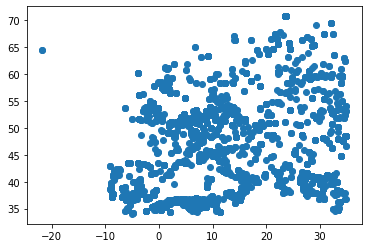

In [ ]:
manager = RunManager(paths, 'PI')
df = manager.update_hotspots('Europe', save=False)
plt.scatter(df.longitude, df.latitude);

The `hotspots_region` name should be defined according with the image bellow. Names with multiple words use `_` in place of the spaces. More info here: https://firms.modaps.eosdis.nasa.gov/active_fire/#firms-txt

In [ ]:
IPython.display.Image(url="https://firms.modaps.eosdis.nasa.gov/images/Regions_500px.jpg")

Running all processes looks like this:

```python
region  = 'PI'
hotspots_region = 'Europe'
paths = ProjectPath('../hide/nrt_test')
weight_files = ['banetv0.20-val2017-fold0.pth', 
                'banetv0.20-val2017-fold1.pth',
                'banetv0.20-val2017-fold2.pth']
manager = RunManager(paths, region)
manager.update_hotspots(hotspots_region)
manager.download_viirs()
manager.preprocess_dataset()
manager.get_preds(weight_files)
```

You can easily run all this process using the console script `banet_nrt_run`.

In [ ]:
# hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_geo.ipynb.
Converted 02_data.ipynb.
Converted 03_models.ipynb.
Converted 04_predict.ipynb.
Converted 04b_nrt.ipynb.
Converted 05_train.ipynb.
Converted 06_cli.ipynb.
Converted index.ipynb.
Converted tutorial.australia2020.ipynb.
